<a href="https://colab.research.google.com/github/sbylash/23_Shasia-Sasa_ML/blob/main/Uts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset [CISIA Webface](https://www.kaggle.com/datasets/ntl0601/casia-webface). Perhatian! Dataset ini cukup besar (2.8Gb) dari 500.000 gambar dan 10.575 subjek (label).

Spesifikasi pengerjaan UTS yang harus dipenuhi adalah:

1. Pelajari tentang CISIA Webface!
2. Dikarenakan data gambar dari CISIA masih dalam 1 direktori besar, Anda perlu melakukan proses split antara data latih dan data uji. Anda dapat melakukan ini secara manual (langsung dari direktori) atau secara logikal dengan listing direktori. (10 poin)
3. Lakukan proses pra pengolahan data. Anda wajib dapat menjelaskan proses pra pengolahan data yang dilakukan. (20 poin)
4. Lakukan proses ekstraksi fitur. Fitur yang digunakan bebas. Anda wajib dapat menjelaskan fitur yang digunakan (30 poin)
5. Buat model NN dengan arsitektur yang kelompok Anda rancang sendiri. Model arsitektur bebas (jumlah layer, jumlah node, fungsi aktivasi). (30 poin)
6. Evaluasi performa model NN kelompok Anda dengan metrik akurasi, *precision*, *recall*, dan *F1-Score*. Jelaskan maksud dari metrik-metrik tersebut!


---

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis. Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ntl0601/casia-webface")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1


# Preparation

In [3]:
# Load required library
# Import Required Library

from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical

# Load Data

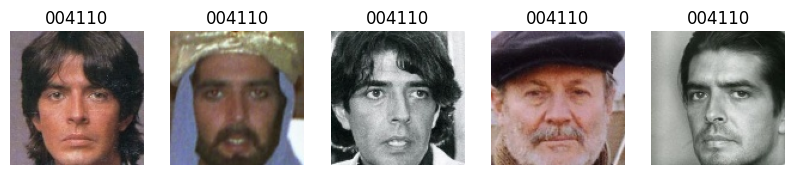

In [4]:
# Bagian ini dapat Anda gunakan untuk melakukan proses loading data dan juga proses split antara data latih dan data uji berdasarkan direktori gambar

# Path dataset
dataset_path = "/root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1/casia-webface"

# Ambil path gambar dan label
image_paths = [os.path.join(root, file)
               for root, _, files in os.walk(dataset_path)
               for file in files]
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Visualisasi gambar
def show_sample_images(image_paths, labels, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Menampilkan 5 gambar
show_sample_images(image_paths, labels)

# Preprocessing

In [5]:
'''
Pada bagian ini Anda diperbolehkan untuk melakukan proses pra pengolahan data (preprocessing) sesuai dengan kebutuhan. Pra pengolahan data dapat berupa:

1. Standardisasi nilai fitur ataupun label
2. Penyesuaian ukuran gambar
3. Perubahan colorspace gambar
4. dan lain-lain
'''

# Ambil semua path gambar
image_paths = [os.path.join(root, file)
               for root, _, files in os.walk(dataset_path)
               for file in files]

# Ambil 100 gambar acak
random.seed(42)
sampled_paths = random.sample(image_paths, min(100, len(image_paths)))

# Membuat list gambar dan label
train_img = [(cv2.imread(path), os.path.basename(os.path.dirname(path))) for path in sampled_paths]

# Ubah ukuran gambar
def standarized_input(image):
    return cv2.resize(image, (1100, 600))

# Fungsi untuk mengencode label
def label_encoder(label):
    return 1 if label == 'day' else 0

# Fungsi preprocessing
def preprocess(img_list):
    std_img_list = []

    for image, label in img_list:
        std_img = standarized_input(image)
        std_img = cv2.cvtColor(std_img, cv2.COLOR_BGR2GRAY)

        img_label = label_encoder(label)

        std_img_list.append((std_img, img_label))

    return std_img_list

# Preprocessing pada gambar yang diambil acak
train_std_img_list = preprocess(train_img)

# Pemeriksaan ukuran gambar yang sudah diproses
pick_random = np.random.randint(0, len(train_std_img_list))
print(f'Image {pick_random}')
print(train_std_img_list[pick_random][0].shape)

Image 37
(600, 1100)


# Features Extraction

In [6]:
'''
Anda dapat melakukan proses ekstraksi fitur apapun sesuai dengan yang Anda inginkan
'''

# Konversi data ke format yang sesuai
X = np.array([img for img, _ in train_std_img_list])
y = np.array([label for _, label in train_std_img_list])

# Ubah bentuk data menjadi 2D (jumlah gambar, tinggi, lebar, channel)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Konversi label ke format one-hot encoding
y = to_categorical(y)

# Membuat model NN
model = Sequential()

# Buat input layer dan hidden layers
model.add(Flatten(input_shape=(600, 1100, 1)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Buat output layer
model.add(Dense(y.shape[1], activation='softmax'))

# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Proses fitting model
history = model.fit(X, y, epochs=30, batch_size=16, validation_split=0.2)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(16, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


5/5 [==============================] - 4s 654ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


5/5 [==============================] - 3s 608ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 3s 618ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 3s 606ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 3s 606ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 3s 615ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 3s 620ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 3s 623ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+0

# Evaluation

In [7]:
'''
Pada bagian ini, lakukan evaluasi terhadap data training dan data testing
'''

# Split data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluasi model menggunakan data testing
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Tampilkan hasil evaluasi
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

1/1 [==============================] - 0s 61ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Loss: 0.0000
Test Accuracy: 1.0000
